In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
from diffusion_models import Weighted_Cascade, Trivalency_Model, Independent_Cascade, Decreasing_Cascade, linear_threshold, general_threshold, Trivalency_Model_Higher_Prob
import pandas as pd
from influence_max_algorithms import MIA

from nbc import non_backtracking_centrality
import pickle

import seaborn as sns


In [47]:
pb2020 = nx.read_gml('/Users/davidguzman/Documents/GitHub/Network-Science-final-Maximization-/Proud_Boys_Datsets/PB2020.gml')

In [48]:
#invert edge direction for PB2020
pb2020 = pb2020.reverse()

In [49]:
#number of nodes and edges
print("Number of nodes: ", pb2020.number_of_nodes())
print("Number of edges: ", pb2020.number_of_edges())

Number of nodes:  13217
Number of edges:  14477


### adding weighted cascade influence 

In [50]:
ICM_model_2020 = Independent_Cascade()
ICM_model_2020.fit(pb2020)
decreasing_cascade_model_2020 = Decreasing_Cascade()
decreasing_cascade_model_2020.fit(pb2020)
weighted_cascade_model_2020 = Weighted_Cascade()
weighted_cascade_model_2020.fit(pb2020)
trivalency_model_2020 = Trivalency_Model_Higher_Prob()
trivalency_model_2020.fit(pb2020)
linear_threshold_model_2020 = linear_threshold()
linear_threshold_model_2020.fit(pb2020)
general_threshold_model_2020 = general_threshold()
general_threshold_model_2020.fit(pb2020)

In [51]:
#load the seeds
with open('seed_wcm.pickle', 'rb') as handle:
    seed_wcm = pickle.load(handle)
    
with open('seed_icm.pickle', 'rb') as handle:
    seed_icm = pickle.load(handle)

with open('seed_dc.pickle', 'rb') as handle:
    seed_dc = pickle.load(handle)

with open('seed_trivalency.pickle', 'rb') as handle:
    seed_trivalency = pickle.load(handle)

with open('seed_lt.pickle', 'rb') as handle:
    seed_lt = pickle.load(handle)

with open('seed_gt.pickle', 'rb') as handle:
    seed_gt = pickle.load(handle)

In [52]:
seed_nodes_and_attributes_df = pd.DataFrame(list(pb2020.nodes))
#name the column 
seed_nodes_and_attributes_df.columns = ['label']

In [53]:
individual_influence_wcm = {}
for label in seed_wcm:
    activate_nums = weighted_cascade_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_wcm[label] = sum(activate_nums)

individual_influence_icm = {}
for label in seed_icm:
    activate_nums = ICM_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_icm[label] = sum(activate_nums)

individual_influence_tr = {}
for label in seed_trivalency:
    activate_nums = trivalency_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_tr[label] = sum(activate_nums)

individual_influence_dc = {}
for label in seed_dc:
    activate_nums = decreasing_cascade_model_2020.monte_carlo_diffusion_all([label], num_simulations=100)
    individual_influence_dc[label] = sum(activate_nums)

individual_influence_lt = {}
for label in seed_lt:
    activate_nums = linear_threshold_model_2020.diffusion_all([label], 0.001)
    individual_influence_lt[label] = sum(activate_nums[1])

individual_influence_gt = {}
for label in seed_gt:
    activate_nums = general_threshold_model_2020.diffusion_all([label])
    individual_influence_gt[label] = sum(activate_nums[1])

------------

In [54]:
def assing_model_probs_to_weights(model):
    pb2020_model = pb2020.copy()
    for edge in pb2020_model.edges():
        prob = model.probability[model.label2id[edge[0]], model.label2id[edge[1]]]

        if pb2020_model.in_degree(edge[0]) == 0: # to avoid division by 0

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob + 0.00000001)) # to avoid diverging to - infinity
        else:

            pb2020_model[edge[0]][edge[1]]['weight'] = prob
            pb2020_model[edge[0]][edge[1]]['weight_negative_log'] = np.abs(np.log(prob))
    return pb2020_model

In [55]:
pb2020c = pb2020.copy()
pb2020c = assing_model_probs_to_weights(weighted_cascade_model_2020)

In [56]:
mia = MIA(pb2020c)
initial_inf = mia.initial_incinf(pb2020c, 0.5)

Starting MIA intialization


100%|██████████| 13217/13217 [00:44<00:00, 296.04it/s]


--------

In [57]:
seed_nodes_and_attributes_df['influence_wcm'] = seed_nodes_and_attributes_df['label'].map(individual_influence_wcm)
seed_nodes_and_attributes_df['influence_icm'] = seed_nodes_and_attributes_df['label'].map(individual_influence_icm)
seed_nodes_and_attributes_df['influence_tr'] = seed_nodes_and_attributes_df['label'].map(individual_influence_tr)
seed_nodes_and_attributes_df['influence_dc'] = seed_nodes_and_attributes_df['label'].map(individual_influence_dc)
seed_nodes_and_attributes_df['influence_lt'] = seed_nodes_and_attributes_df['label'].map(individual_influence_lt)
seed_nodes_and_attributes_df['influence_gt'] = seed_nodes_and_attributes_df['label'].map(individual_influence_gt)

In [58]:
# add the influence as an attribute to the nodes in the network using the dictionary
nx.set_node_attributes(pb2020, individual_influence_wcm, 'influence_wcm')
nx.set_node_attributes(pb2020, individual_influence_icm, 'influence_icm')
nx.set_node_attributes(pb2020, individual_influence_tr, 'influence_tr')
nx.set_node_attributes(pb2020, individual_influence_dc, 'influence_dc')
nx.set_node_attributes(pb2020, individual_influence_lt, 'influence_lt')
nx.set_node_attributes(pb2020, individual_influence_gt, 'influence_gt')

In [59]:
# get the attributes of the nodes in the network and store them in a dataframe
seed_nodes_and_attributes_df = pd.DataFrame.from_dict(dict(pb2020.nodes(data=True)), orient='index')
#add the label column with the content of the index 
seed_nodes_and_attributes_df['label'] = seed_nodes_and_attributes_df.index
#drop 'listed', 'cdate','symmetry', 'asymmetry', 'tsymmetry', 'tasymmetry', 'allsym', 'days', 'trate', 'frate', 'tfrate', 'seed', 'core'
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.drop(['listed', 'cdate','symmetry', 'asymmetry', 'tsymmetry', 'tasymmetry', 'allsym', 'days', 'trate', 'frate', 'tfrate', 'seed', 'core'], axis=1)


In [60]:
# Export the graph to GEXF
nx.write_gexf(pb2020, "pb2020_with_influences.gexf")

In [61]:
seed_nodes_and_attributes_df

,faves,followers,friends,statuses,influence_wcm,influence_icm,influence_tr,influence_dc,influence_lt,influence_gt,label
ColoradoPOYB,1.0,12.0,9.0,5.0,6.86,10.00,4.05,10.00,10.0,10.0,ColoradoPOYB
IStand4Trump,859.0,5068.0,5124.0,21071.0,1.93,22.24,NaN,41.75,11.0,11.0,IStand4Trump
RallyPb,1.0,133.0,186.0,10.0,2.27,56.51,NaN,39.09,11.0,11.0,RallyPb
mtn_pb,5311.0,317.0,431.0,514.0,1.96,40.04,NaN,26.86,11.0,11.0,mtn_pb
Darktwistysnow,1327.0,54.0,349.0,2436.0,1.60,5.80,NaN,5.90,11.0,11.0,Darktwistysnow
...,...,...,...,...,...,...,...,...,...,...,...
Proudboy13,NaN,NaN,NaN,NaN,3.00,3.00,NaN,3.00,3.0,3.0,Proudboy13
proudboy2012,NaN,NaN,NaN,NaN,64.00,64.00,17.80,64.00,64.0,64.0,proudboy2012
proudboy_,NaN,NaN,NaN,NaN,198.89,604.35,79.98,605.81,1342.0,199.0,proudboy_
ProudBoyzLondon,NaN,NaN,NaN,NaN,13.89,NaN,6.16,NaN,18.0,18.0,ProudBoyzLondon


### adding traditional centrality metrics 

In [62]:
base_df = pd.DataFrame(list(pb2020.nodes))
#name the column 
base_df.columns = ['label']

base_df['influence_wcm'] = base_df['label'].map(individual_influence_wcm)
base_df['influence_icm'] = base_df['label'].map(individual_influence_icm)
base_df['influence_tr'] = base_df['label'].map(individual_influence_tr)
base_df['influence_dc'] = base_df['label'].map(individual_influence_dc)
base_df['influence_lt'] = base_df['label'].map(individual_influence_lt)
base_df['influence_gt'] = base_df['label'].map(individual_influence_gt)

In [63]:
seed_nodes_and_centralities_df = base_df
#drop nan values
#seed_nodes_and_centralities_df = seed_nodes_and_centralities_df.dropna()

In [64]:
degree_centrality_dict = nx.degree_centrality(pb2020)
seed_nodes_and_centralities_df['degree_centrality'] = seed_nodes_and_centralities_df['label'].map(degree_centrality_dict)
closeness_centrality_dict = nx.closeness_centrality(pb2020)
seed_nodes_and_centralities_df['closeness_centrality'] = seed_nodes_and_centralities_df['label'].map(closeness_centrality_dict)
betweenness_centrality_dict = nx.betweenness_centrality(pb2020)
seed_nodes_and_centralities_df['betweenness_centrality'] = seed_nodes_and_centralities_df['label'].map(betweenness_centrality_dict)
#eigenvector_centrality_dict = nx.eigenvector_centrality(pb2020)
#seed_nodes_and_centralities_df['eigenvector_centrality'] = seed_nodes_and_centralities_df['label'].map(eigenvector_centrality_dict)
pagerank_dict = nx.pagerank(pb2020)
seed_nodes_and_centralities_df['pagerank'] = seed_nodes_and_centralities_df['label'].map(pagerank_dict)
k_core_centralities_dict = nx.core_number(pb2020)
seed_nodes_and_centralities_df['k_core_centrality'] = seed_nodes_and_centralities_df['label'].map(k_core_centralities_dict)

In [65]:
#add k-core centrality to the graph
nx.set_node_attributes(pb2020, k_core_centralities_dict, 'k_core_centrality')

In [66]:
# Export the graph to GEXF
nx.write_gexf(pb2020, "pb2020_with_influences.gexf")

In [67]:
pb2020_int = nx.convert_node_labels_to_integers(pb2020)
#get the node labels in a list
node_labels = list(pb2020.nodes())
# calcualate the non-backtrack centrality
non_backtrack_centralities = non_backtracking_centrality(pb2020_int)
# use node labels to create a dictionary
non_backtrack_centralities_dict = dict(zip(node_labels, non_backtrack_centralities))
# add the non-backtrack centrality to the dataframe
seed_nodes_and_centralities_df['non_backtrack_centrality'] = seed_nodes_and_centralities_df['label'].map(non_backtrack_centralities_dict)

In [68]:
seed_nodes_and_centralities_df

,label,influence_wcm,influence_icm,influence_tr,influence_dc,influence_lt,influence_gt,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,k_core_centrality,non_backtrack_centrality
0,ColoradoPOYB,6.86,10.00,4.05,10.00,10.0,10.0,0.001438,0.041696,0.000069,0.000142,4,0.002724
1,IStand4Trump,1.93,22.24,NaN,41.75,11.0,11.0,0.000151,0.000000,0.000000,0.000020,2,0.000373
2,RallyPb,2.27,56.51,NaN,39.09,11.0,11.0,0.000151,0.000000,0.000000,0.000020,2,0.000373
3,mtn_pb,1.96,40.04,NaN,26.86,11.0,11.0,0.000151,0.000000,0.000000,0.000020,2,0.000373
4,Darktwistysnow,1.60,5.80,NaN,5.90,11.0,11.0,0.000076,0.000000,0.000000,0.000020,1,0.000108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13212,EnglishRocker93,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049
13213,Felllicism,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049
13214,WeightLoss54,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049
13215,Redecembr,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049


### adding node propeties

In [69]:
base_df = pd.DataFrame(list(pb2020.nodes))
#name the column 
base_df.columns = ['label']

base_df['influence_wcm'] = base_df['label'].map(individual_influence_wcm)
base_df['influence_icm'] = base_df['label'].map(individual_influence_icm)
base_df['influence_tr'] = base_df['label'].map(individual_influence_tr)
base_df['influence_dc'] = base_df['label'].map(individual_influence_dc)
base_df['influence_lt'] = base_df['label'].map(individual_influence_lt)
base_df['influence_gt'] = base_df['label'].map(individual_influence_gt)

In [70]:
seed_nodes_and_properties_df  = base_df
#drop nan values
#seed_nodes_and_properties_df = seed_nodes_and_properties_df.dropna()

In [71]:
in_degree_dict = dict(pb2020.in_degree())
seed_nodes_and_properties_df['in_degree'] = seed_nodes_and_properties_df['label'].map(in_degree_dict)
out_degree_dict = dict(pb2020.out_degree())
seed_nodes_and_properties_df['out_degree'] = seed_nodes_and_properties_df['label'].map(out_degree_dict)
average_neighbor_degree_dict = nx.average_neighbor_degree(pb2020, source = 'out', target = 'out')
seed_nodes_and_properties_df['average_neighbor_degree'] = seed_nodes_and_properties_df['label'].map(average_neighbor_degree_dict)
#eccentricity_dict = nx.eccentricity(pb2020) #network is not strongly connected
#seed_nodes_and_properties_df['eccentricity'] = seed_nodes_and_properties_df['label'].map(eccentricity_dict)

In [72]:
seed_nodes_and_properties_df

,label,influence_wcm,influence_icm,influence_tr,influence_dc,influence_lt,influence_gt,in_degree,out_degree,average_neighbor_degree
0,ColoradoPOYB,6.86,10.00,4.05,10.00,10.0,10.0,10,9,0.0
1,IStand4Trump,1.93,22.24,NaN,41.75,11.0,11.0,0,2,61.0
2,RallyPb,2.27,56.51,NaN,39.09,11.0,11.0,0,2,61.0
3,mtn_pb,1.96,40.04,NaN,26.86,11.0,11.0,0,2,61.0
4,Darktwistysnow,1.60,5.80,NaN,5.90,11.0,11.0,0,1,9.0
...,...,...,...,...,...,...,...,...,...,...
13212,EnglishRocker93,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1.0
13213,Felllicism,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1.0
13214,WeightLoss54,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1.0
13215,Redecembr,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1.0


## plotting

### attributes

In [ ]:
# plot scatterplots for each attribute in one plot wiht seaborn with correlation lines and coefficients numbers added to the plot
sns.pairplot(seed_nodes_and_attributes_df, kind="reg")
#add title to the plot
plt.suptitle('Scatterplots of node influence and attributes', fontsize=16)


/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_33628/1764994779.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(seed_nodes_and_attributes_df.corr(), annot=True, cmap=colormap)


Text(0.5, 1.0, 'Correlation matrix of node influence and attributes')

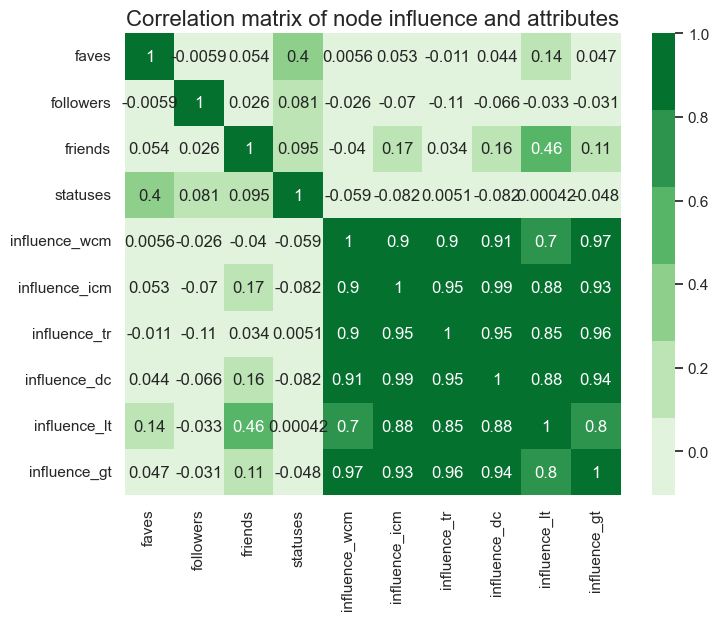

In [74]:
#print correlation matrix
sns.set(rc={'figure.figsize':(8,6)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_attributes_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and attributes', fontsize=16)

### centralities

Text(0.5, 0.98, 'Scatterplots of node influence and centralities')

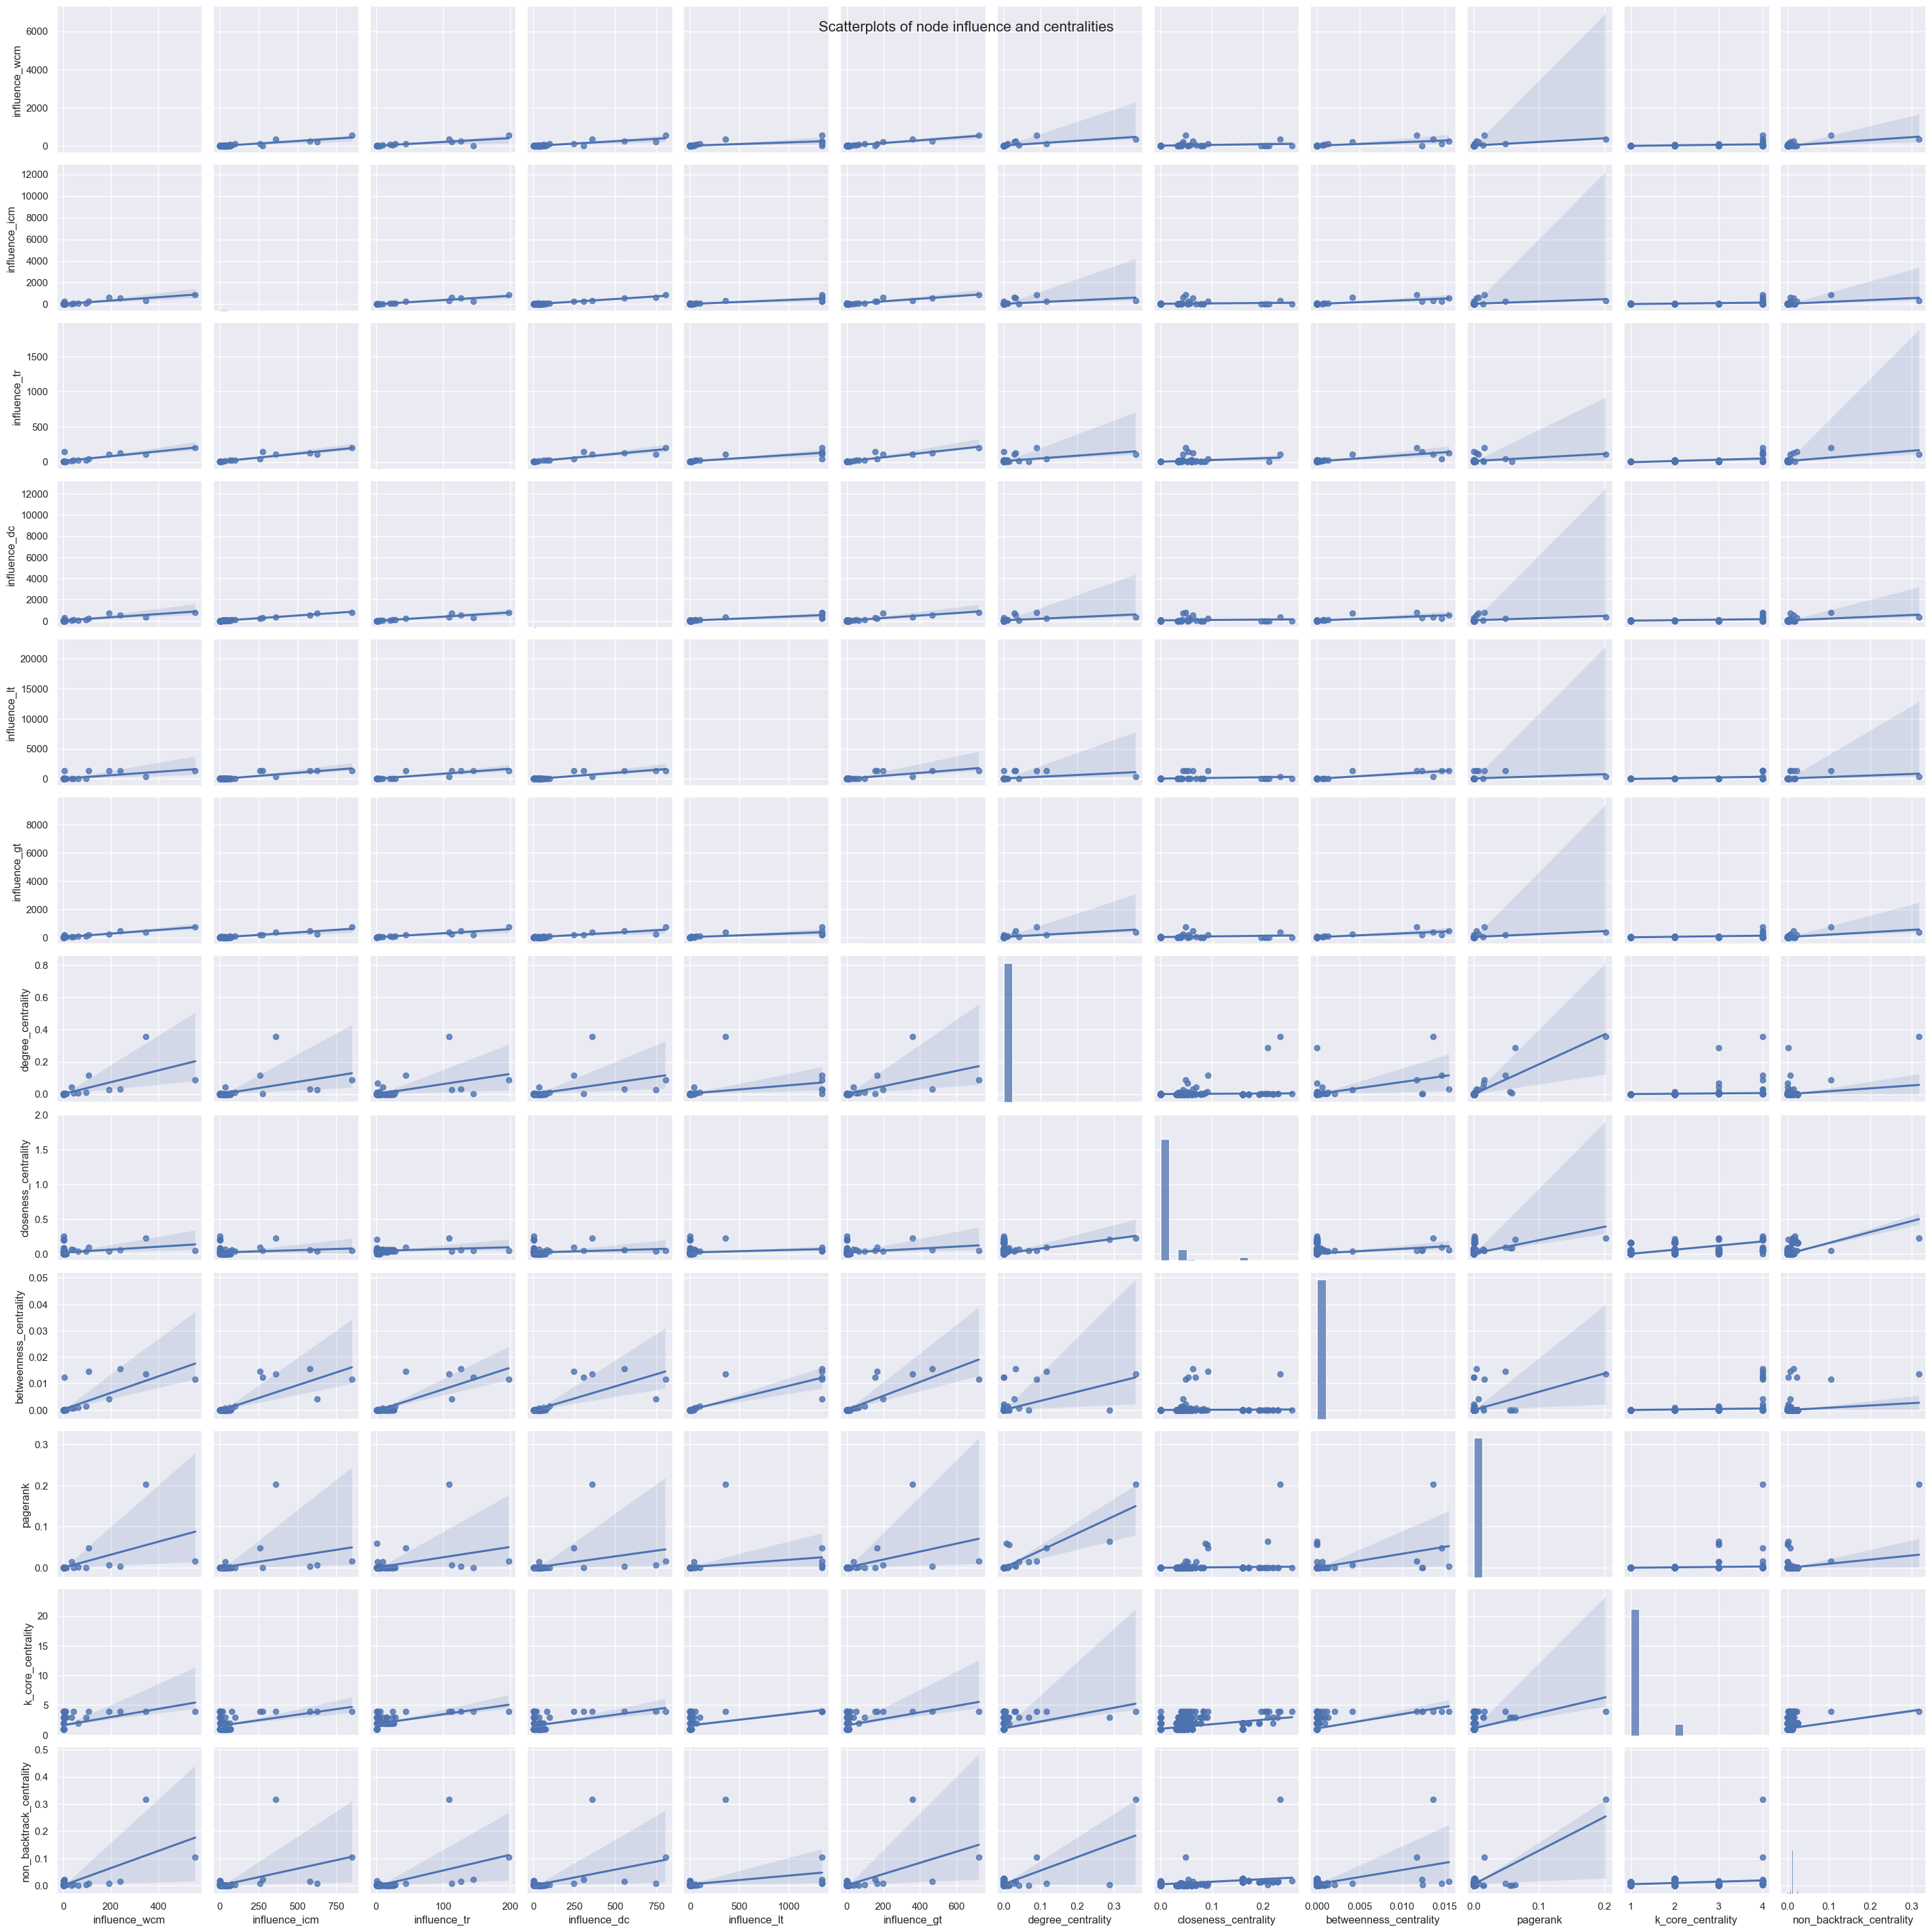

In [ ]:
sns.pairplot(seed_nodes_and_centralities_df, kind="reg")
#add title to the plot
plt.suptitle('Scatterplots of node influence and centralities', fontsize=16)

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_29861/3241212256.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(seed_nodes_and_centralities_df.corr(), annot=True, cmap=colormap)


Text(0.5, 1.0, 'Correlation matrix of node influence and centralities')

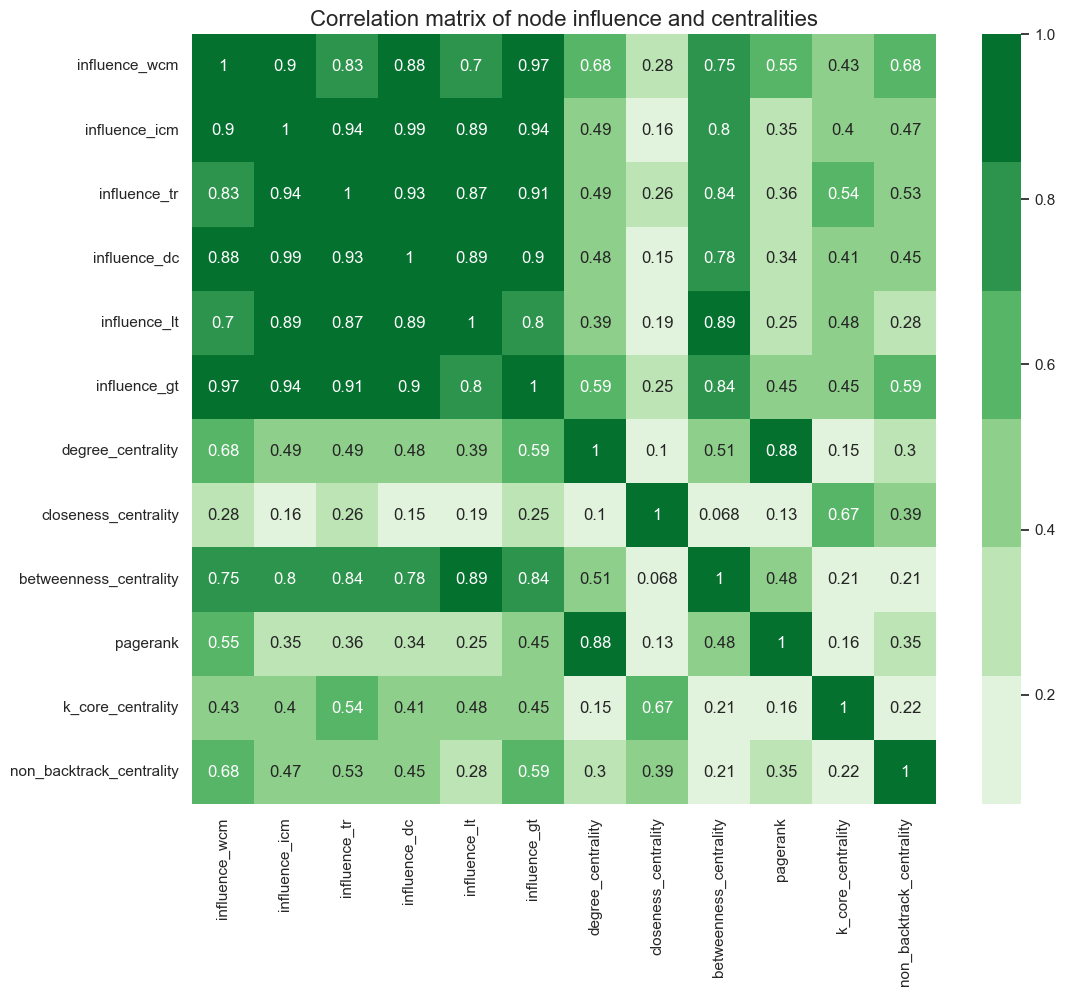

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_centralities_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and centralities', fontsize=16)

### node properties

Text(0.5, 0.98, 'Scatterplots of node influence and properties')

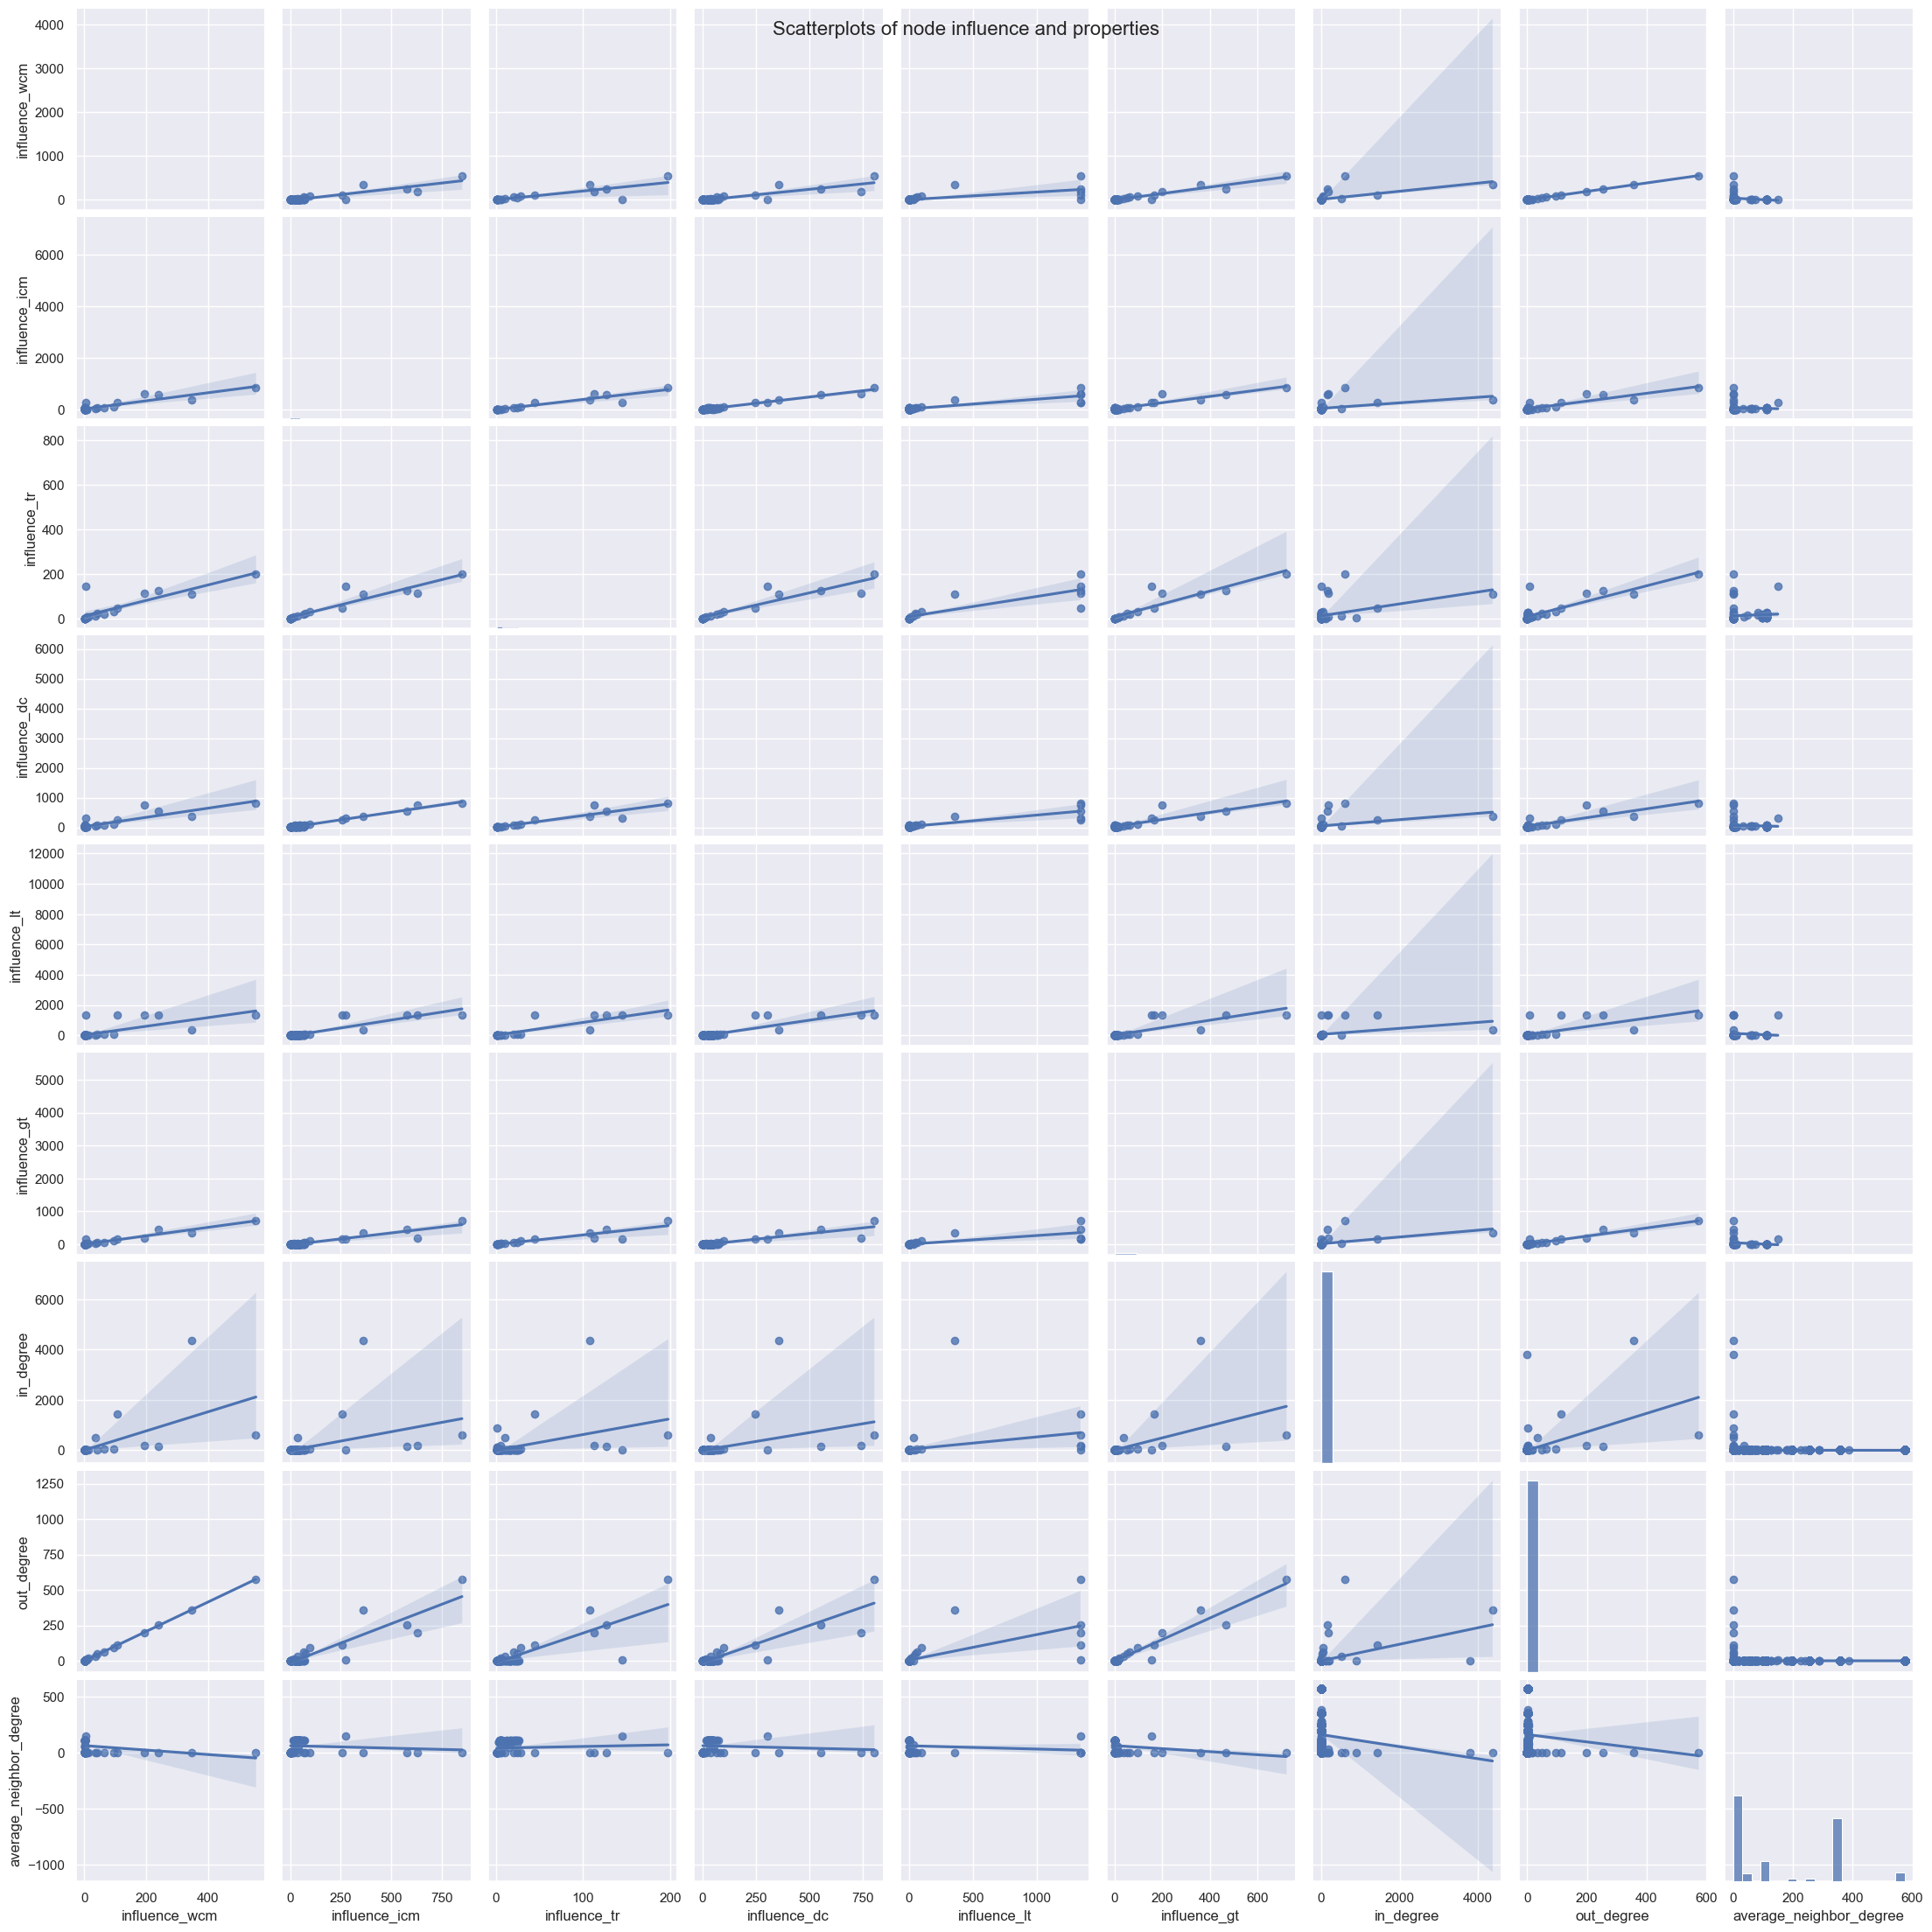

In [ ]:
sns.pairplot(seed_nodes_and_properties_df, kind="reg")
#add title to the plot
plt.suptitle('Scatterplots of node influence and properties', fontsize=16)

/var/folders/pn/sswhj3651l545xrjmmzd77_h0000gn/T/ipykernel_29861/4021183938.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(seed_nodes_and_properties_df.corr(), annot=True, cmap=colormap)


Text(0.5, 1.0, 'Correlation matrix of node influence and properties')

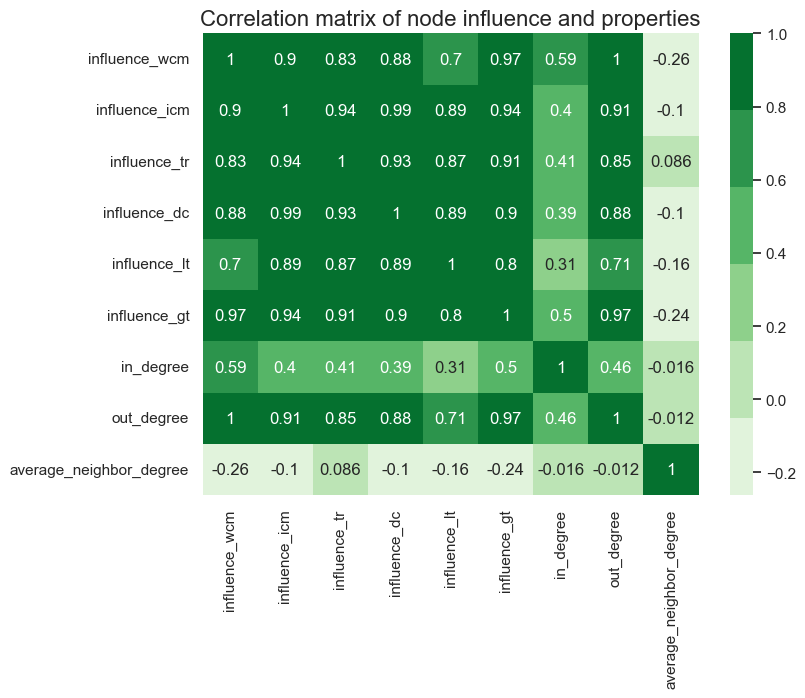

In [ ]:
sns.set(rc={'figure.figsize':(8,6)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_properties_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and properties', fontsize=16)

In [80]:
#join the dataframes
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.set_index('label')
seed_nodes_and_centralities_df = seed_nodes_and_centralities_df.set_index('label')
seed_nodes_and_centralities_df = seed_nodes_and_properties_df.set_index('label')

,influence_wcm,influence_icm,influence_tr,influence_dc,influence_lt,influence_gt,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,k_core_centrality,non_backtrack_centrality
label,,,,,,,,,,,,
ColoradoPOYB,6.86,10.00,4.05,10.00,10.0,10.0,0.001438,0.041696,0.000069,0.000142,4,0.002724
IStand4Trump,1.93,22.24,NaN,41.75,11.0,11.0,0.000151,0.000000,0.000000,0.000020,2,0.000373
RallyPb,2.27,56.51,NaN,39.09,11.0,11.0,0.000151,0.000000,0.000000,0.000020,2,0.000373
mtn_pb,1.96,40.04,NaN,26.86,11.0,11.0,0.000151,0.000000,0.000000,0.000020,2,0.000373
Darktwistysnow,1.60,5.80,NaN,5.90,11.0,11.0,0.000076,0.000000,0.000000,0.000020,1,0.000108
...,...,...,...,...,...,...,...,...,...,...,...,...
EnglishRocker93,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049
Felllicism,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049
WeightLoss54,NaN,NaN,NaN,NaN,NaN,NaN,0.000076,0.000000,0.000000,0.000020,1,0.000049


In [82]:
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.join(seed_nodes_and_centralities_df, lsuffix='_left', rsuffix='_right')
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.join(seed_nodes_and_properties_df)


In [87]:
# remove influence_wcm_left, influence_icm_left, influence_tr_left, influence_dc_left, influence_lt_left, influence_gt_left, influence_wcm_right, influence_icm_right, influence_tr_right, influence_dc_right, influence_lt_right, influence_gt_right
seed_nodes_and_attributes_df = seed_nodes_and_attributes_df.drop(columns=['influence_wcm_left', 'influence_icm_left', 'influence_tr_left', 'influence_dc_left', 'influence_lt_left', 'influence_gt_left', 'influence_wcm_right', 'influence_icm_right', 'influence_tr_right', 'influence_dc_right', 'influence_lt_right', 'influence_gt_right'])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0, 0.5, 'faves'),
  Text(0, 1.5, 'followers'),
  Text(0, 2.5, 'friends'),
  Text(0, 3.5, 'statuses'),
  Text(0, 4.5, 'degree_centrality'),
  Text(0, 5.5, 'closeness_centrality'),
  Text(0, 6.5, 'betweenness_centrality'),
  Text(0, 7.5, 'pagerank'),
  Text(0, 8.5, 'k_core_centrality'),
  Text(0, 9.5, 'non_backtrack_centrality'),
  Text(0, 10.5, 'influence_wcm'),
  Text(0, 11.5, 'influence_icm'),
  Text(0, 12.5, 'influence_tr'),
  Text(0, 13.5, 'influence_dc'),
  Text(0, 14.5, 'influence_lt'),
  Text(0, 15.5, 'influence_gt'),
  Text(0, 16.5, 'in_degree'),
  Text(0, 17.5, 'out_degree'),
  Text(0, 18.5, 'average_neighbor_degree')])

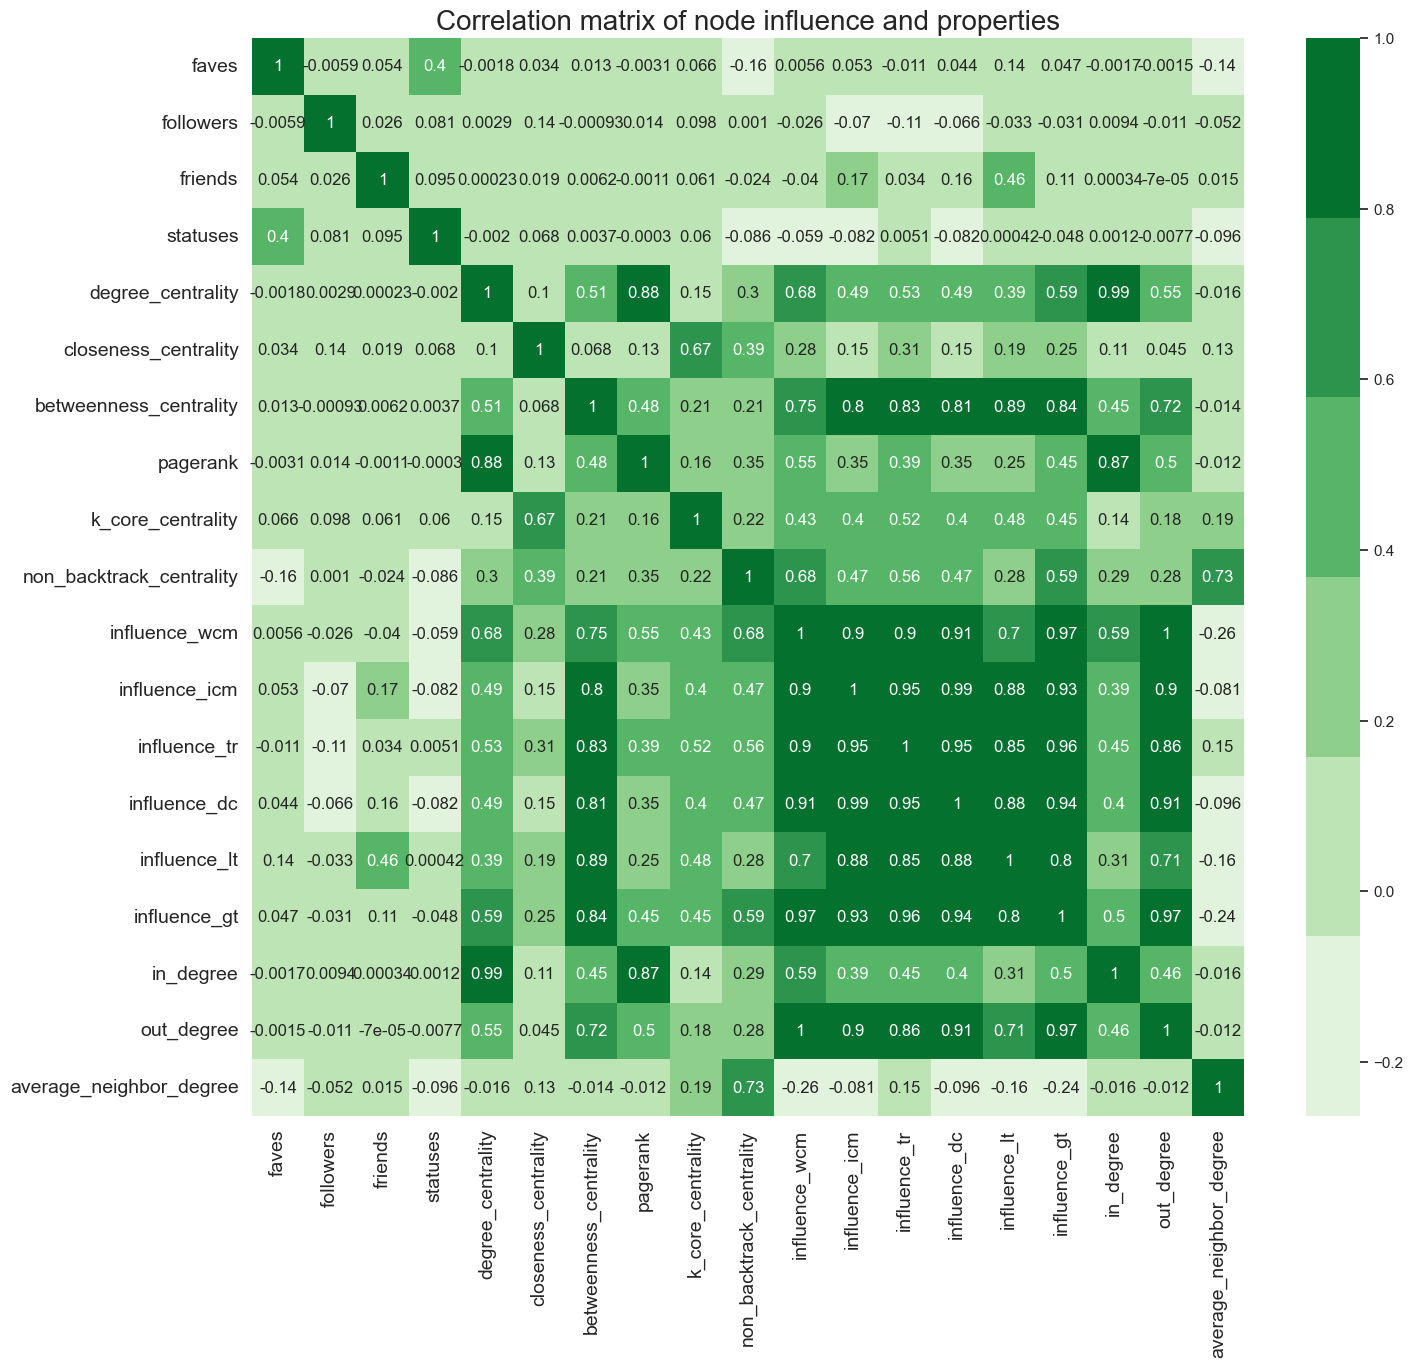

In [91]:
sns.set(rc={'figure.figsize':(16,14)})
colormap = sns.color_palette("Greens")
sns.heatmap(seed_nodes_and_attributes_df.corr(), annot=True, cmap=colormap)
#add title to the plot
plt.title('Correlation matrix of node influence and properties', fontsize=20)
#make the axes labels bigger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)